## Milestone 1:
For the first milestone, each team should complete the following steps for the offered grade:

- Define the software environment (e.g. requirements.txt, Dockerfile, etc.)
- Data acquisition: indicating the data source, and how you downloaded it (Python script or IPYNB)
- Data preparation. Final output: training, validation and test inputs and outputs. (Python script or IPYNB)
- Containerization : initial version of the Dockerfile to be used later

To complete milestone 1, create a GitHub repository for your group with the following in readme.md:

- team name,
- team members' names and Neptun codes,
- project description,
- functions of the files in the repository,
- related works (papers, GitHub repositories, blog posts, etc),
-and how to run it (building and running the container, running your solution within the container).

In this assignment, you have to submit the URL of the solution. One submission per group is asked and needed.

Imports

In [25]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torchvision.datasets import Food101
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from PIL import Image

Reprodukálhatóság érdekében beállítunk egy seedet.

In [26]:
torch.manual_seed(42)

### Data acquisition and analysis
Torchvisionben is elérhető flowers102 és OxfordIIIPet dataset kerül letöltésre kódból, amiket transzformálunk, hogy egységesek legyenek.

In [27]:
flowers_dataset = Flowers102(root="./data", split="train", transform=None, download=True)
foods_dataset = Food101(root="./data", split="train", transform=None, download=True, )
print(flowers_dataset)
print(foods_dataset)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=train
Dataset Food101
    Number of datapoints: 75750
    Root location: ./data
    split=train


Nézzük meg, hogy a datasetek képeinek milyen az osztály szerinti eloszlása, illetve mekkorák a képek.


In [28]:
def plot_class_size_distribution(dataset, dataset_name):
    # Get the labels (class) for each image
    classes = [label for _, label in dataset]

    # Count the occurrences of each class
    class_counts = Counter(classes)

    # Get the class sizes (number of samples per class)
    class_sizes = list(class_counts.values())

    # Plot the histogram of class sizes
    plt.figure(figsize=(10, 6))
    sns.histplot(class_sizes, bins=30, kde=False)  # kde=False means no smooth curve, just bars
    plt.title(f"Class Size Distribution in {dataset_name} Dataset")
    plt.xlabel("Number of Samples per Class")
    plt.ylabel("Number of Classes")
    plt.show()

Flowers102 Dataset Class Distribution


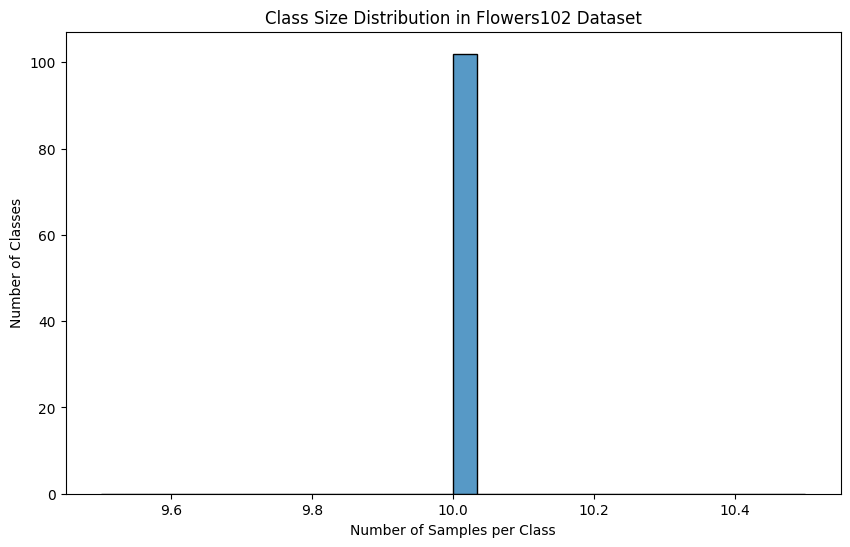


Food101 Dataset Class Distribution


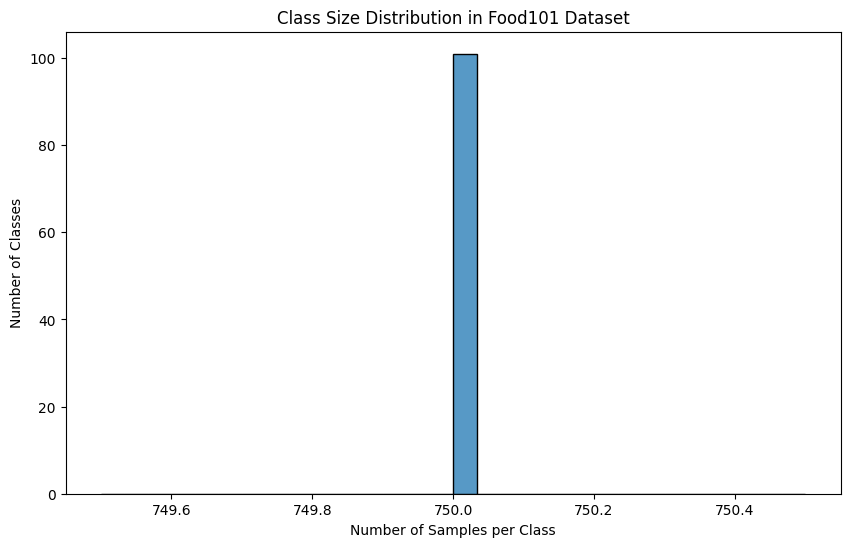

In [29]:
print("Flowers102 Dataset Class Distribution")
plot_class_size_distribution(flowers_dataset, "Flowers102")

print("\nFood101 Dataset Class Distribution")
plot_class_size_distribution(foods_dataset, "Food101")

Az előző két diagram alapján azt lehet mondani, hogy a flowers102 datasetben nincsenek eltérések eloszlást nézve, hiszen minden osztályban 10 minta van, illetve a food101 datasetben sincsenek nagy eltérések, így ebből a szempontból mindkét dataset megfelelő.


In [30]:
def categorize_resolution(width, height):
    if width < 256 and height < 256:
        return 'Low (<256)'
    elif 256 <= width < 512 and 256 <= height < 512:
        return 'Medium (256-512)'
    elif 512 <= width < 1024 and 512 <= height < 1024:
        return 'High (512-1024)'
    else:
      return 'Very High (>=1024)'


def plot_image_size_distribution(dataset, dataset_name):
    resolution_counts = {
        'Low (<256)': 0,
        'Medium (256-512)': 0,
        'High (512-1024)': 0,
        'Very High (>=1024)': 0
    }
    for img, _ in dataset:
        if isinstance(img, str):
            img = Image.open(img)
        category = categorize_resolution(img.size[0], img.size[1])
        resolution_counts[category] += 1

    categories = list(resolution_counts.keys())
    counts = list(resolution_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.title(f'Image Size Distribution of {dataset_name} by Resolution Category')
    plt.xlabel('Resolution Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    plt.show()


Flowers102 Dataset Image Size Analysis


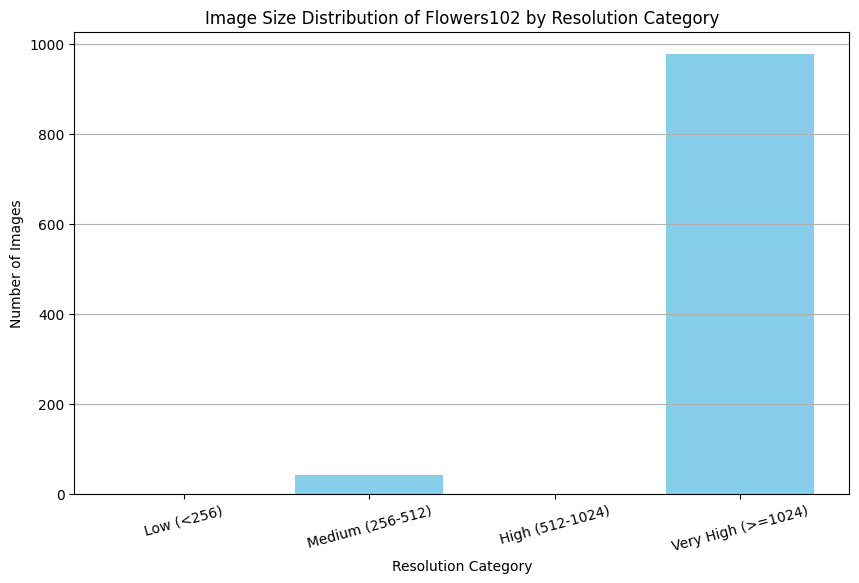


Food101 Dataset Image Size Analysis


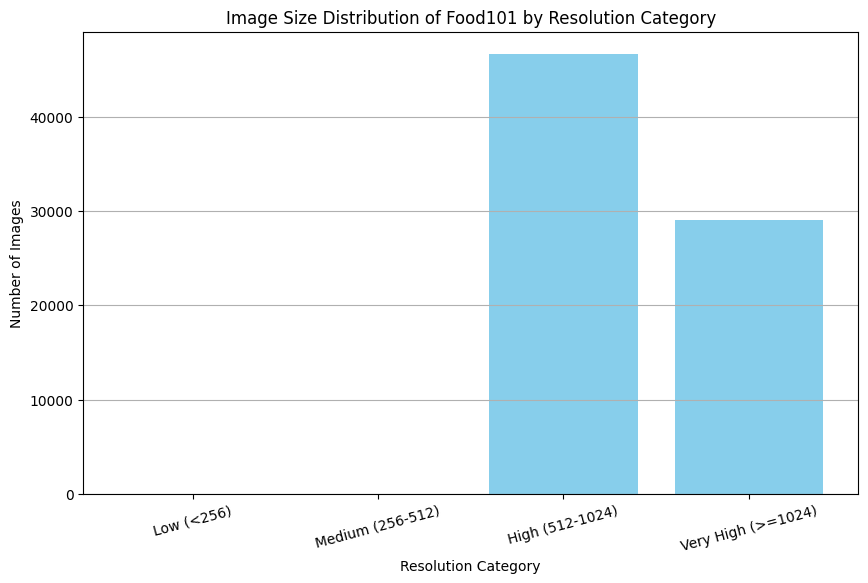

In [31]:
print("\nFlowers102 Dataset Image Size Analysis")
plot_image_size_distribution(flowers_dataset, "Flowers102")

print("\nFood101 Dataset Image Size Analysis")
plot_image_size_distribution(foods_dataset, "Food101")

Mivel 256x256 méretre resizeolunk ezért ezek alapján sincs további teendő.


### Data preparation


Véletlenszerűen szétválasztjuk a datasetet a következő arányok szerint:
- Train: 70%
- Validation: 15%
- Test: 15%


In [32]:
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    return random_split(dataset, [train_size, val_size, test_size])

In [34]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
flowers_dataset = Flowers102(root="./data", split="train", transform=train_transform, download=True)
foods_dataset = Food101(root="./data", split="train", transform=train_transform, download=True)

In [35]:
flowers102_train, flowers102_val, flowers102_test = split_dataset(flowers_dataset)

foods_train, foods_val, foods_test = split_dataset(foods_dataset)

In [36]:
batch_size=32

In [37]:

flowers102_train_loader = DataLoader(flowers102_train, batch_size=batch_size, shuffle=True)
flowers102_val_loader = DataLoader(flowers102_val, batch_size=batch_size, shuffle=False)
flowers102_test_loader = DataLoader(flowers102_test, batch_size=batch_size, shuffle=False)

foods_train_loader = DataLoader(foods_train, batch_size=batch_size, shuffle=True)
foods_val_loader = DataLoader(foods_val, batch_size=batch_size, shuffle=False)
foods_test_loader = DataLoader(foods_test, batch_size=batch_size, shuffle=False)

In [38]:
print(f"Flowers102 dataset: {len(flowers102_train)} training, {len(flowers102_val)} validation, {len(flowers102_test)} test samples")
print(f"Food101 dataset: {len(foods_train)} training, {len(foods_val)} validation, {len(foods_test)} test samples")

Flowers102 dataset: 714 training, 153 validation, 153 test samples
Food101 dataset: 53025 training, 11362 validation, 11363 test samples
